### Code used in Chapter 4: DFT Numerics

Import some important libraries. Most Python distributions do not come with pyFFTW, might need to pip install pyfftw.

In [5]:
import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from scipy import integrate
import time
import pyfftw
from numba import autojit
%matplotlib inline

Define functions for central difference based on the 4th-order isotropic central difference stencil.
<img src="grid.png" alt="central difference grid" style="width: 500px;"/>

Function `shift` gets the stencil values around each $(m,n)$ and stores them in an intermediate array. These intermediate arrays are multiplied by the corresponding weights in function `centralDiffNumexpr` (`centralDiffShift` is a non-numexpr equivalent).

In [10]:
@autojit
def shift(A,num):
    E = np.empty_like(A)
    F = np.empty_like(A)
    G = np.empty_like(A)
    H = np.empty_like(A)
    
    E[:num] = A[-num:]
    E[num:] = A[:-num]
    F[:-num] = A[num:]
    F[-num:] = A[:num]
    
    G[:,:num] = A[:,-num:]
    G[:,num:] = A[:,:-num]
    H[:,:-num] = A[:,num:]
    H[:,-num:] = A[:,:num]
    return E + F + G + H

@autojit
def centralDiffShift(A,h,Nx):
    A = A**3
    D = np.empty_like((Nx,Nx))
    D = -1.*shift(A,2)+ 16.*shift(A,1) - 60.*A
    return D/(12.*h**2)

# def centralDiffNumexpr(A,h,Nx):
#     A = ne.evaluate('A**3')
#     F = shift(A,2)
#     E = shift(A,1)
#     D = np.empty_like(A)
#     D = ne.evaluate('(-1.*F + 16.*E - 60.*A) / (12.*h**2)')
#     return D

Initialise wisdom to None for pyFFTW.

In [7]:
wisdom = None

The main looping consisting of the Strang-Splitting involving:

    Substep 1: Fourier-PS (eqn 4.5a)
    Substep 2: Strong Stability Preserving 3rd-order Runge Kutta + 4th-order central finite difference scheme (eqn 4.5b)
    Substep 3: Fourier-PS (eqn 4.5c)

Energy is calculated from the free energy functional (eqn 1.1a), and the average concentration from (eqn 1.1b).

time taken1: 3.84
time taken2: 13.49
time taken3: 4.17
total time taken: 21.50


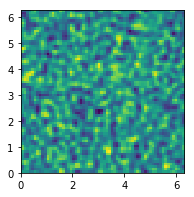

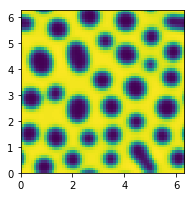

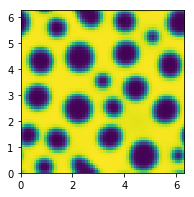

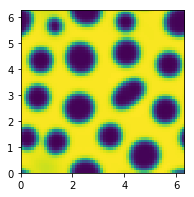

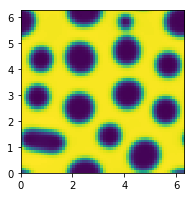

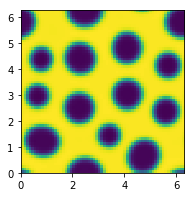

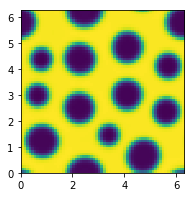

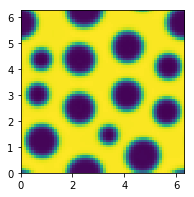

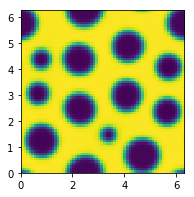

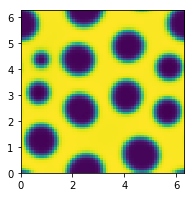

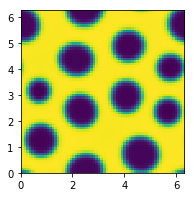

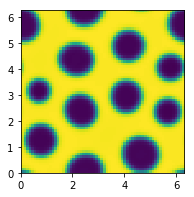

In [11]:
# L = length of domain; Nx = spatial resolution;
# h = spatial stepsize; dx = 1D spatial grid;
# dt = temporal stepsize
L = 2.*np.pi
Nx = 64
h = L/Nx
dx = np.linspace(0,L,Nx)
dt = 0.001

# define small parameters.
eps = 0.08
sigma = 0.5

# u-bar == m.
m = 0.33

# number of iterations
it = 15000
it += 1

# lv defines the levels for which sampling of the systems are made, e.g. sampling of energy and average concentration.
lv = int(it/100)

# define seed and uniform distribution.
seed = 693
np.random.seed(seed)
r = np.random.uniform(-1.,1.,(Nx,Nx))

# zeroing the mean of the uniform distribution.
if r.mean()<0:
    r -= r.mean()
else:
    r += r.mean()

# a scaling factor
C = 0.01

# a constant
tpiL = 2.*np.pi/L

# initialise arrays for pyFFTW.
u = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
v = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
vp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)
vpp = pyfftw.empty_aligned((Nx,Nx), dtype='complex128', n=16)

# define initial conditions.
u[:,:] = m + C*r

# get wavenumber/frequency grids (k2 == k^2; k4 == k^4)
freqs = np.fft.fftfreq(Nx,(1.0/float(Nx)))
kx, ky = np.meshgrid(freqs,freqs)
k = kx + ky
k2 = kx**2+ky**2
k4 = k2**2

# initialise arrays to store avg. concentration and eneergy values.
avgConc = np.zeros(it/lv+1)
energy = np.zeros(it/lv+1)

# if there is wisdom for FFT plans, import it.
if wisdom != None:
    pyfftw.import_wisdom(wisdom)
    
# define pyFFTW plans for the forward and inverse FFTs.
fft_object = pyfftw.FFTW(u, vpp, threads=4, axes=(0,1))
ifft_object = pyfftw.FFTW(vpp, v, direction='FFTW_BACKWARD', threads=4, axes=(0,1))
    
fft_object = pyfftw.FFTW(v, vp, threads=4, axes=(0,1))
ifft_object = pyfftw.FFTW(vp, u, direction='FFTW_BACKWARD', threads=4, axes=(0,1))

# initialise some counters.
j = 0
t1 = 0
t2 = 0
t3 = 0
    
for i in xrange(it+1):
    # the first Strang-splitting substep (eqn 4.5a): Fourier-PS.
    tic1 = time.time()
    vpp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(u)
    v = ifft_object(vpp).real
    toc1 = time.time()
    t1 += (toc1-tic1)
    
    # the second Strang-splitting substep (eqn 4.5b): SSP-RK3.
    tic2 = time.time()
    Fu = centralDiffShift(v,h,Nx)
    v1 = ne.evaluate('v + dt * (Fu + sigma*m)')
    Fu = centralDiffShift(v1,h,Nx)
    v2 = ne.evaluate('3./4. * v + 1./4. * v1 + 1./4. * dt * (Fu + sigma*m)')
    Fu = centralDiffShift(v2,h,Nx)
    v = ne.evaluate('1./3. * v + 2./3. * v2 + 2./3. * dt * (Fu + sigma*m)')
    toc2 = time.time()
    t2 += (toc2-tic2)
    
    # the third Strang-splitting substep (eqn 4.5c): Fourier-PS.
    tic3 = time.time()
    vp = np.exp(0.5*(-1.*eps**2*k4*tpiL**4+k2*tpiL**2-sigma)*dt)*fft_object(v)
    u = ifft_object(vp).real
    toc3 = time.time()
    t3 += (toc3-tic3)
    
    # plot intermediate morphologies.
#     if i%int((it-1)/10)==0:
#         fig1 = plt.figure(figsize=(3,3))
#         plt.imshow(u,origin='left', extent=[0,L,0,L])
    
    # sample energy and average concentration at levels.
    if i%lv==0:
        dim = 2
        u0 = u
        
        # get average concentration.
        for d in range(dim):
            u0 = integrate.trapz(u0,dx)
        avgConc[j] = u0 / L**2
        
        # get energy.
        T1 = -1.j * k * tpiL * np.fft.fft2(u)
        T1 = np.real(np.fft.ifft2(T1))
        T1 = 0.5*eps**2*abs(T1)**2

        T2 = 1./4*(np.real(u)**2-1.)**2

        up = np.real(u)-m
        for d in range(dim):
            up = integrate.trapz(up,dx)
        T3 = -1.*up
        T3 = 0.5*sigma*abs(T3)**2

        en = T1 + T2 + T3
        en = np.real(en)
        for d in range(dim):
            en = integrate.trapz(en,dx)
        energy[j] = en
        j += 1

wisdom = pyfftw.export_wisdom()

# normalise against initial energy. Possible since energy is unitless.
energy /= energy[0]

# save array outputs
# np.savetxt('uArray-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), u)
# np.savetxt('energy-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), energy)
# np.savetxt('avgConc-dt=%s,it=%s,Nx=%s,sigma=%s,m=%s,seed=%s.txt' %(dt,it,Nx,sigma,m,seed), avgConc)

# print time taken.
print("time taken1: %.2f" %(t1))
print("time taken2: %.2f" %(t2))
print("time taken3: %.2f" %(t3))
print("total time taken: %.2f" %(t1+t2+t3))

# plot final figure.
fig = plt.figure(figsize=(3,3))
plt.imshow(u,origin='left', extent=[0,L,0,L])

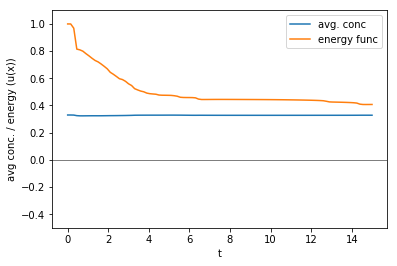

In [13]:
# plot energy and avg. conc.
# generate temporal grid.
t = np.arange(0,it/lv+1)*dt*lv

fig2 = plt.figure()
ax = plt.gca()
ax.set_ylim([-.5,1.1])
plt.xlabel('t')
plt.ylabel('avg conc. / energy (u(x))')
plt.plot(t,avgConc)
plt.plot(t,energy)
plt.legend(['avg. conc','energy func','delta energy'])
plt.axhline(y=0, linewidth=0.5, color='k')
plt.show()

# export pdf figure, if needed.
# fig2.savefig("enconc03.pdf", bbox_inches='tight')